In [78]:
from coffea.util import load
import datetime
import matplotlib.pyplot as plt
import mplhep as hep
import yaml
import dill
import pandas as pd
plt.style.use('seaborn-v0_8-white')
plt.rcParams['figure.dpi'] = 200 # Change for higher resolution
hep.style.use('CMS')

import numpy as np
#from axo_studies import hist_selection, reco_objects, l1_objects
%load_ext autoreload
%autoreload 2
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Available triggers:
- DST_PFScouting_AXONominal
- DST_PFScouting_ZeroBias
- DST_PFScouting_ZeroBias_DST_PFScouting_AXONominal
- DST_PFScouting_ZeroBias_DST_PFScouting_ZeroBias

Available histograms:
- L1Jet_L1Jet_mass
- L1EG_L1EG_mass
- L1Mu_L1Mu_mass
- ScoutingPFJet_ScoutingPFJet_mass
- ScoutingElectron_ScoutingElectron_mass
- ScoutingMuonVtx_ScoutingMuonVtx_mass


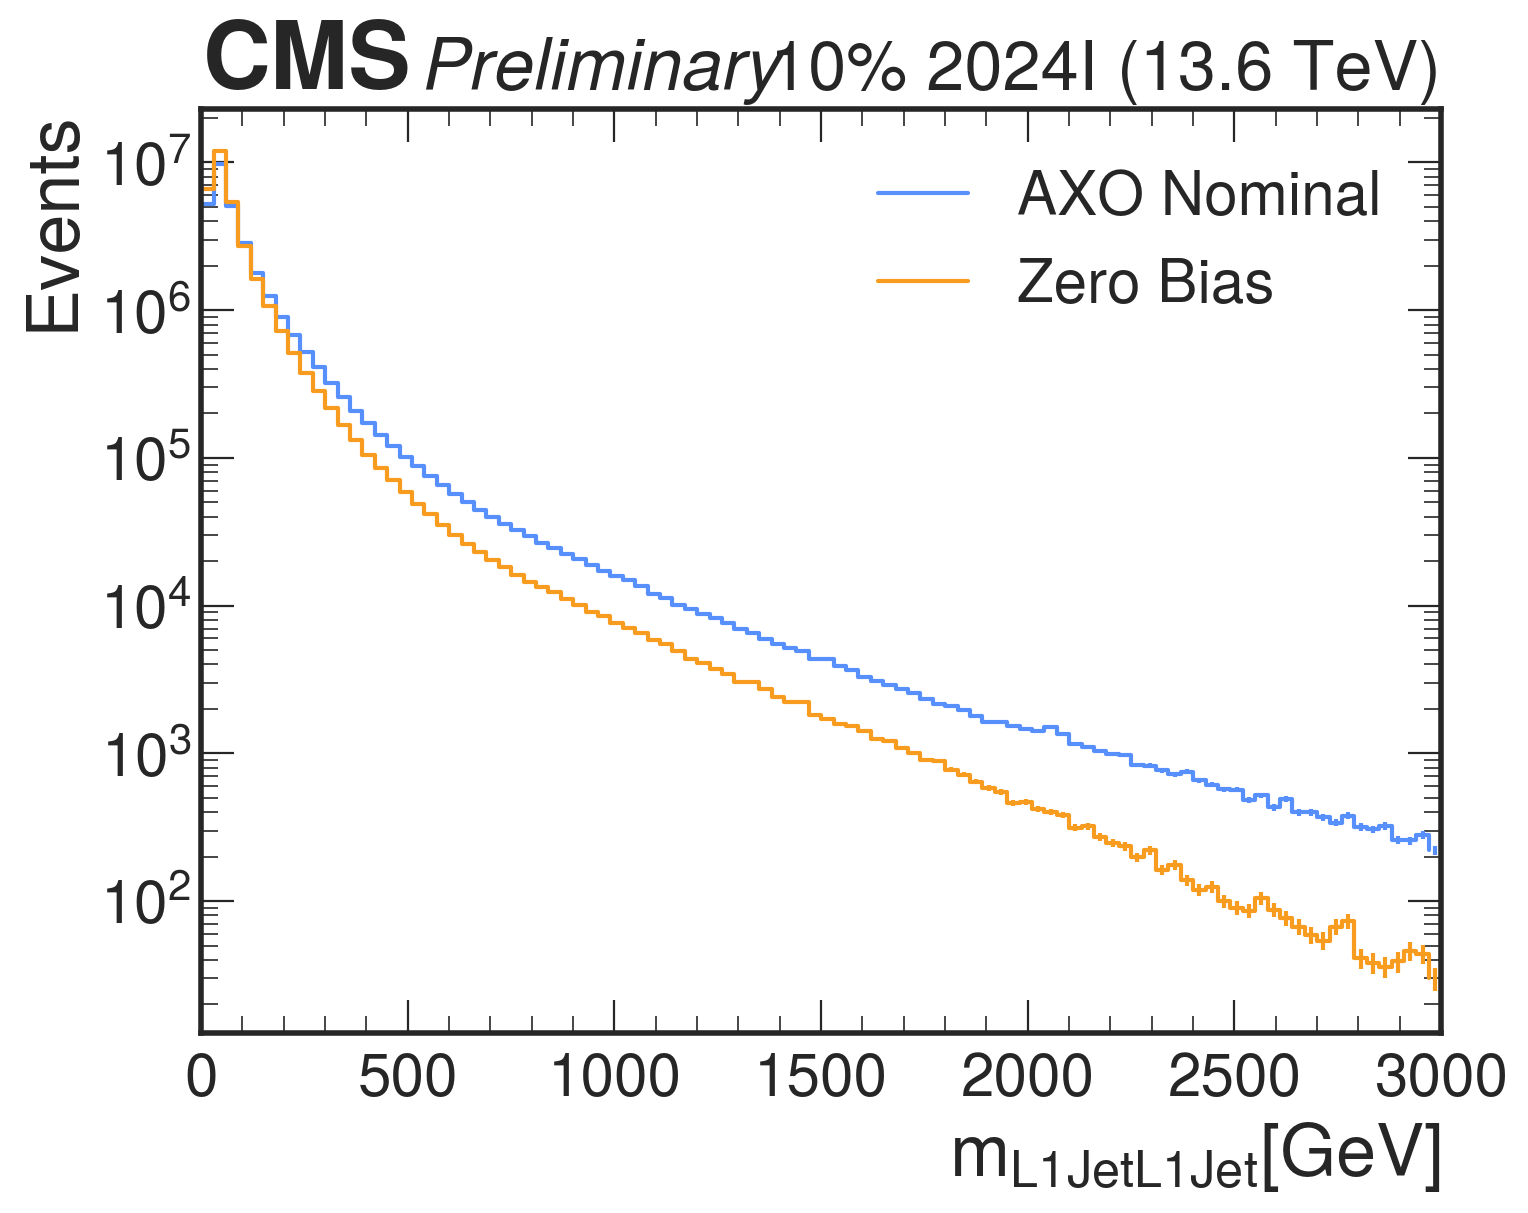

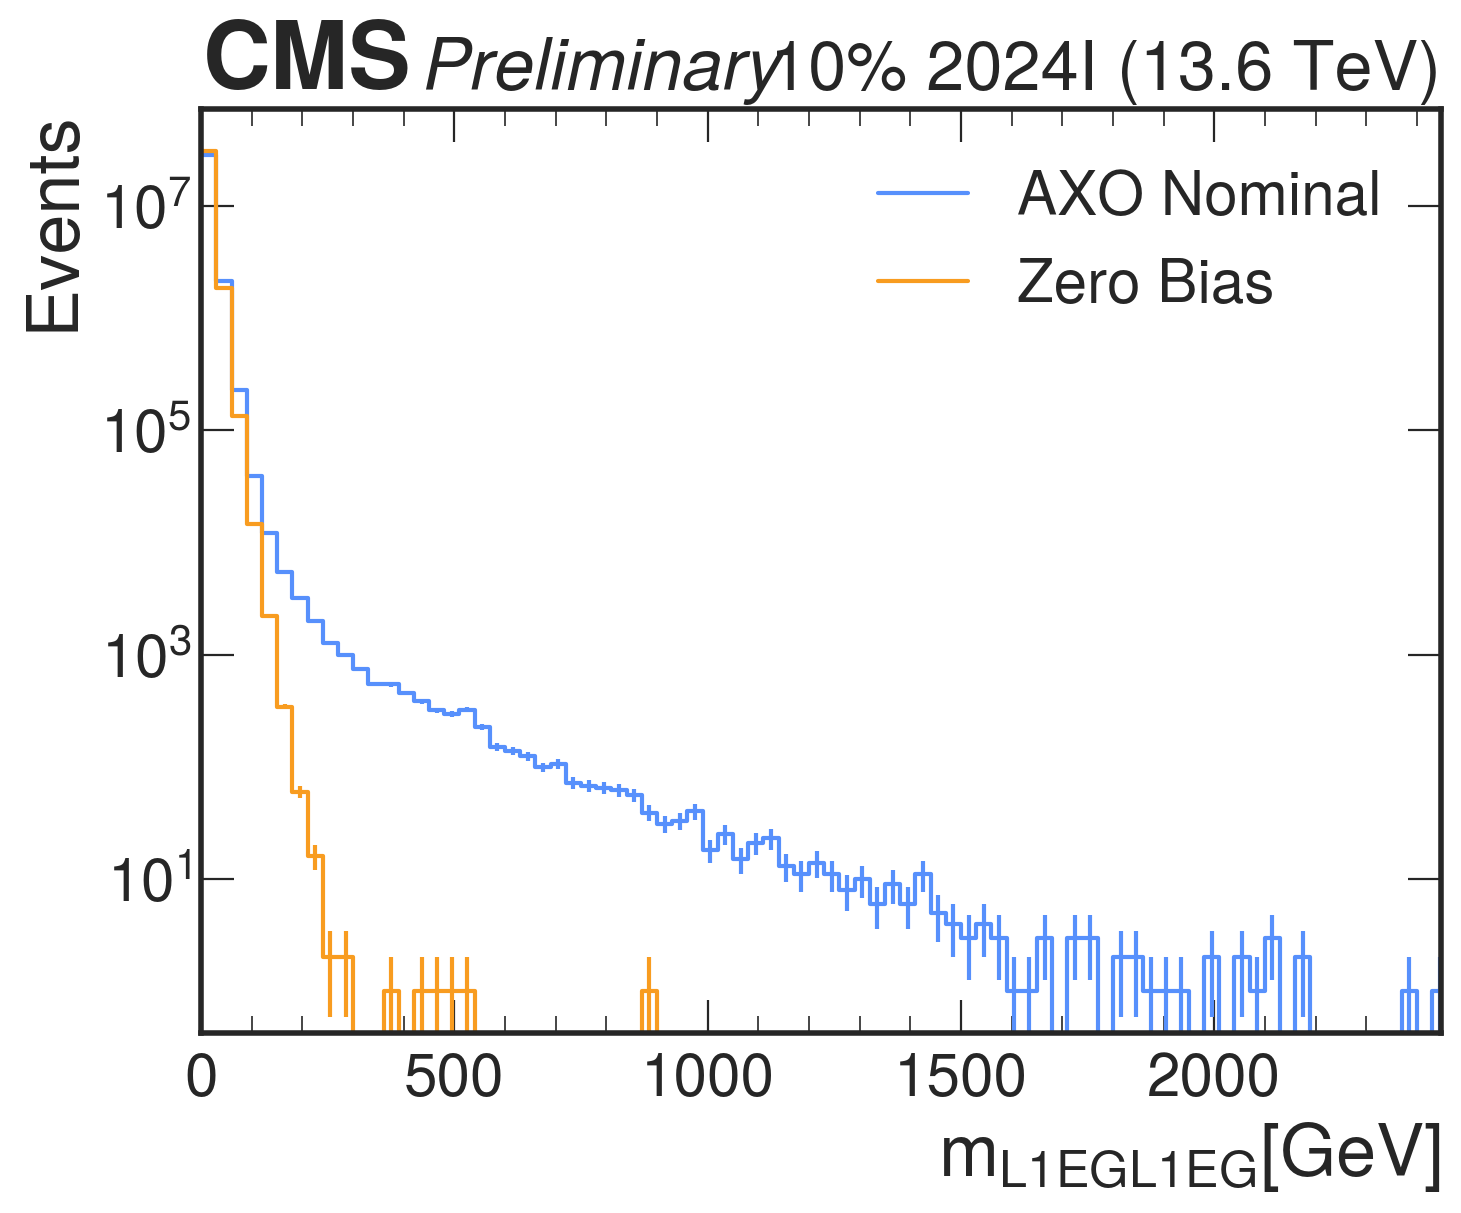

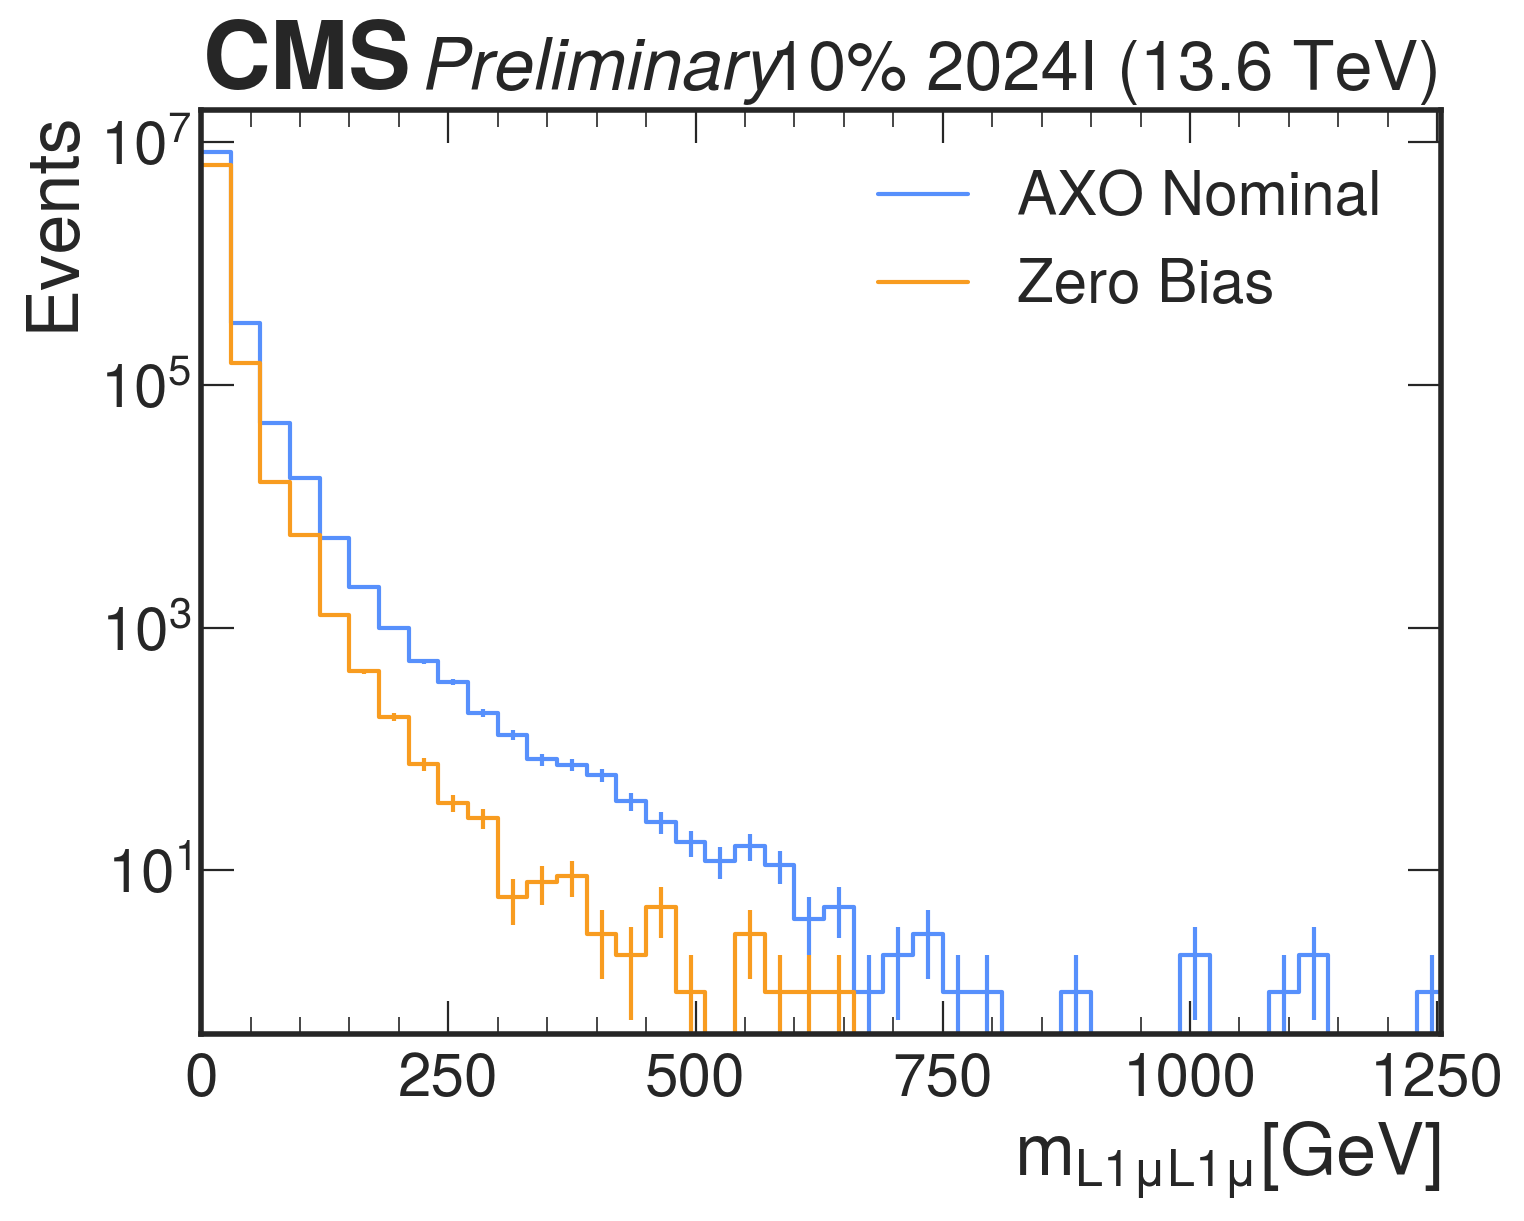

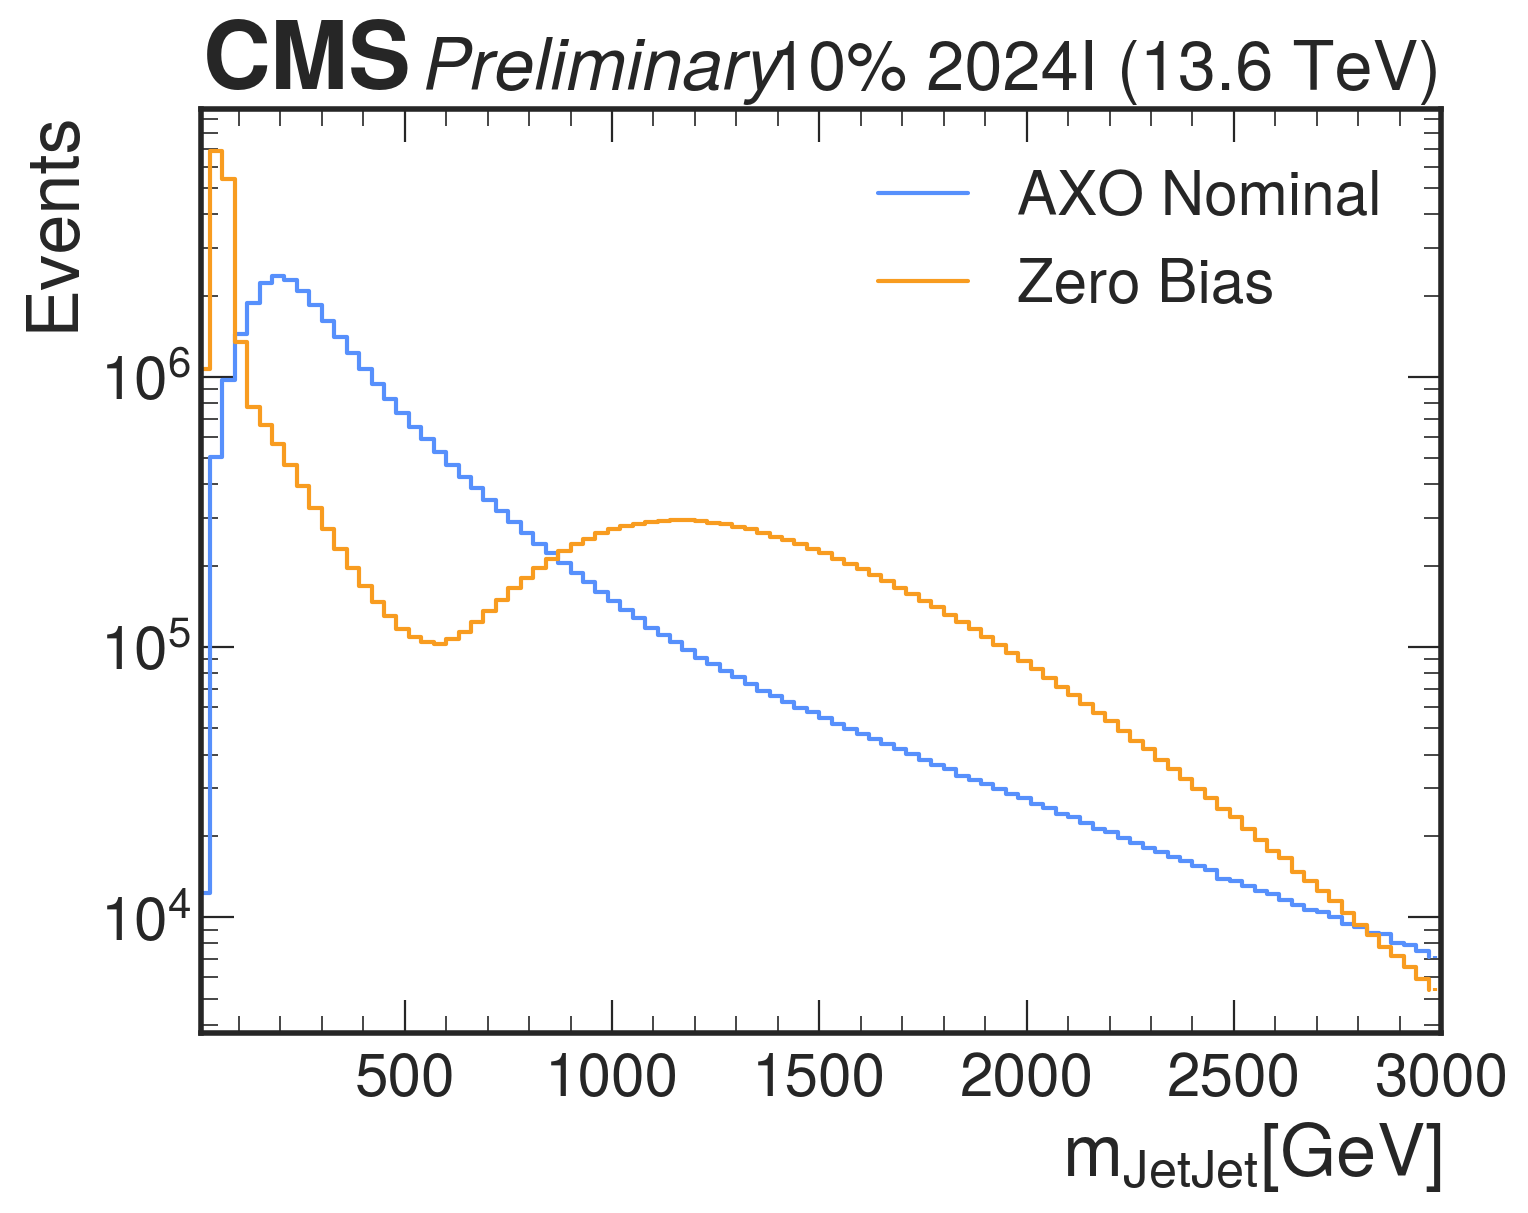

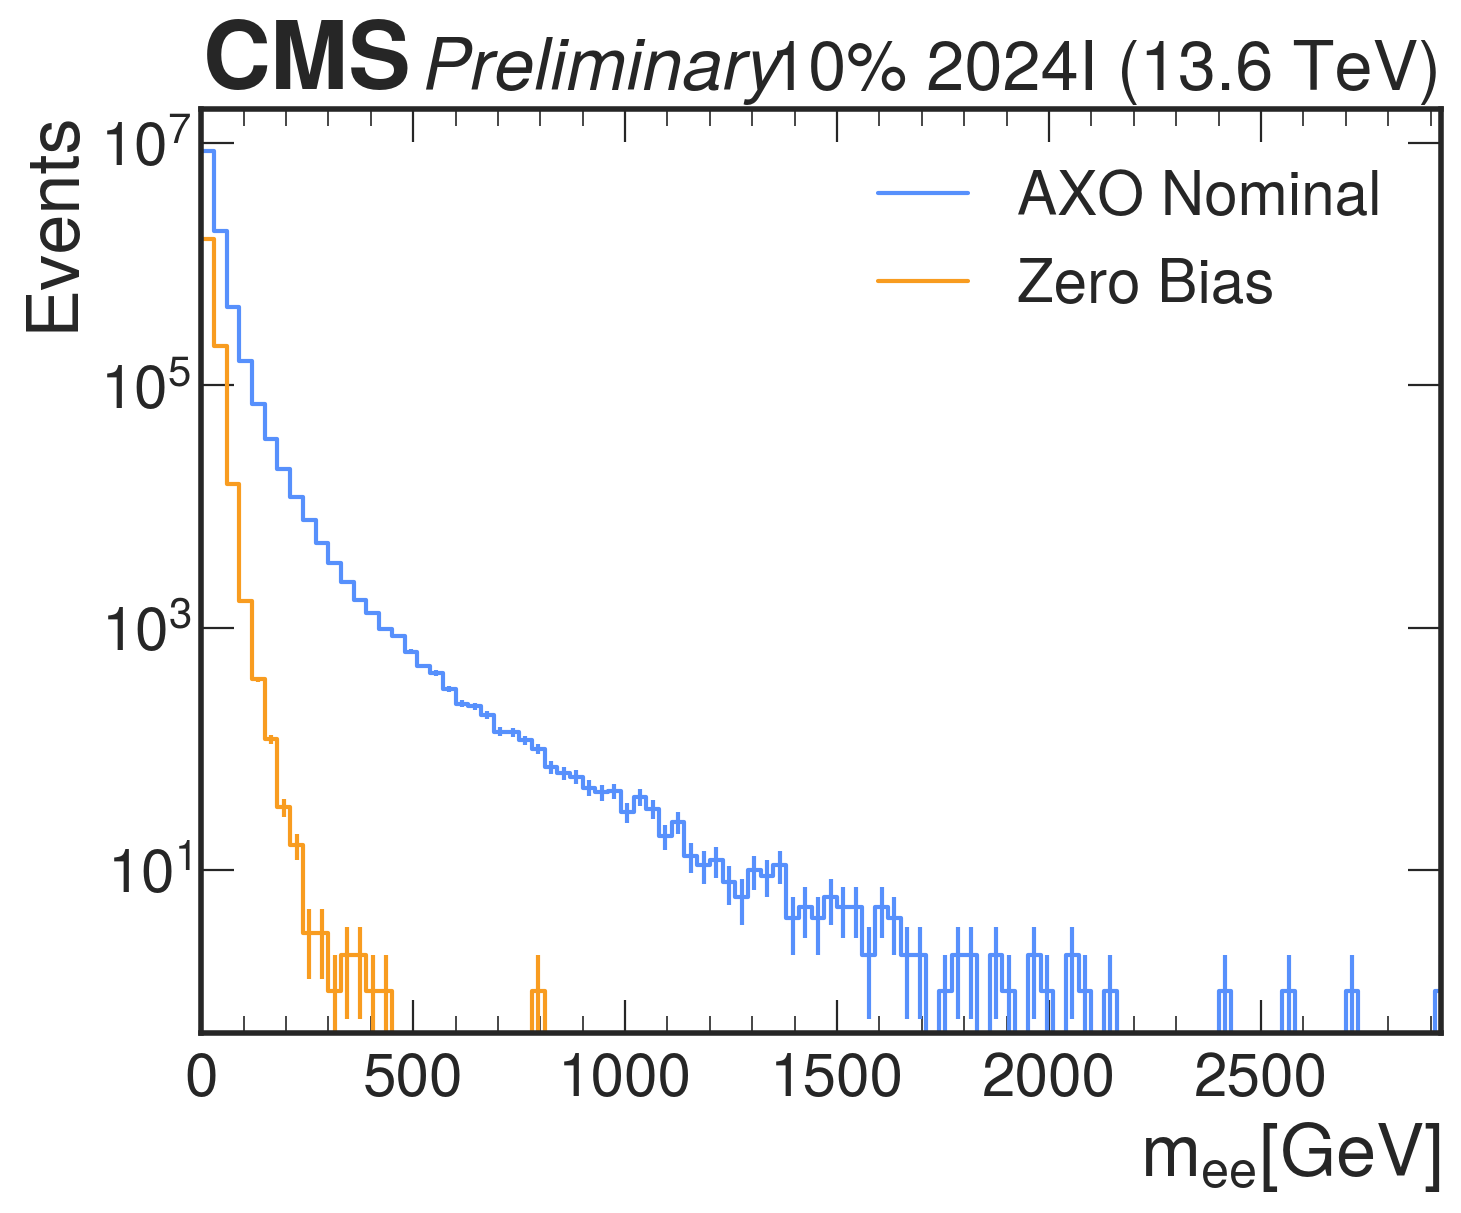

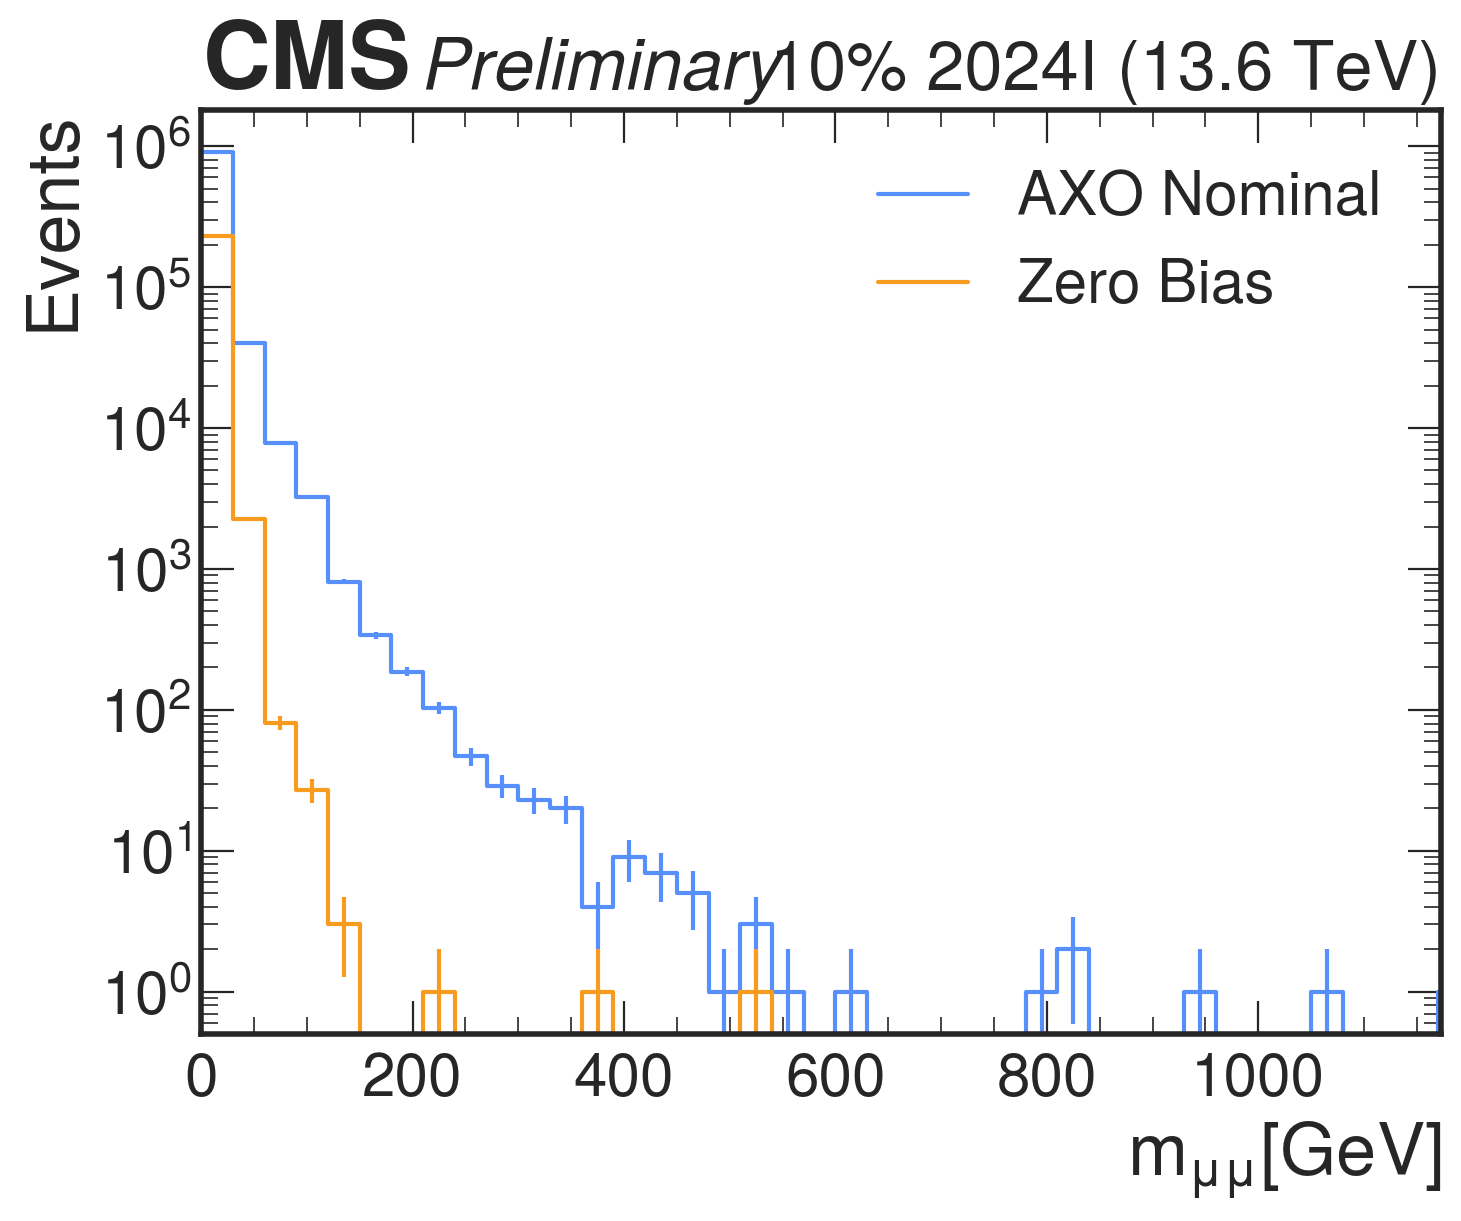

In [80]:

config_filename = "config.yaml"
plotting_config_filename = "plotting_config.yaml"
                                            
with open(config_filename, 'r') as stream:
    config = yaml.safe_load(stream)
with open(plotting_config_filename, 'r') as stream:
    plotting_config = yaml.safe_load(stream)
    
dataset = config["dataset_name"]
todays_date = datetime.date.today().strftime('%Y%m%d')

hist_result_filename = f'hist_result_{dataset}_{todays_date}.pkl'          # file name containing histograms
 # load file with histograms
with open(hist_result_filename, 'rb') as file:
    hist_result = dill.load(file)
#hist_result = load(hist_result_filename)


cutflow = hist_result[dataset]['cutflow']
# Convert list of dictionaries to a single dictionary (merge entries)
cutflow_merged = {k: v for d in cutflow for k, v in d.items()}
# Create a DataFrame with one row
df = pd.DataFrame.from_dict(cutflow_merged,orient="index", columns=["Events"])
df

print("Available triggers:")  
for trigger in hist_result[dataset]['trigger']:
    print("- "+trigger)

print("\nAvailable histograms:")
for hist in hist_result[dataset]['hists']:
    print("- "+hist)
    


def auto_zoom_x(hist):
    filled = hist.values() > 0
    filled_temp = filled[0][0]
    for i in range(len(filled[0])):
        filled_temp = np.logical_or(filled_temp,filled[0][i])
    
    lowest = np.min(hist.axes.edges[2].flatten()[0:-1][filled_temp])
    highest = np.max(hist.axes.edges[2].flatten()[1:][filled_temp])
    return [lowest, highest]

def label_maker(hist_name):
    label = "None"
    splitted = hist_name.split("_")
    # print("Splitted", splitted)
    prefix = splitted[0:1][0]
    suffix = splitted[-1:][0]
    if len(splitted)>2:
        middle=splitted[1:-1][0]
        # print(prefix)
        # print(middle)
        # print(suffix)

        if middle == prefix: #di-object
            prefix = plotting_config["object_label_templates"][prefix]
            middle = plotting_config["object_label_templates"][middle]
            label = plotting_config["label_templates"]['diobject'][suffix].format(middle,prefix)
        else:
            prefix = plotting_config["object_label_templates"][prefix]
            label = plotting_config["label_templates"]['object'][suffix].format(prefix,middle)
            
    else:
        if prefix == "l1":
            label = "L1 "+plotting_config["label_templates"]['totals'][suffix]
        elif prefix == "scouting":
            label = "Scouting "+plotting_config["label_templates"]['totals'][suffix]
        elif prefix == "full_reco":
            label = "Scouting "+plotting_config["label_templates"]['totals'][suffix]
        elif prefix == "anomaly":
            label = plotting_config["label_templates"]['totals'][hist_name]
        else:
            label = plotting_config["label_templates"]['object_type'][suffix].format(prefix)
        
    # print("Final label:",label)
    return label

#label_maker("L1Jet_L1Jet_mass")
#label_maker('anomaly_score')
for hist in hist_result[dataset]['hists']:
    xlabel = label_maker(hist)

def get_trigger_label(trigger,plotting_config):
    label = ""
    split = trigger.split("_")
    if len(split)>3: # orthogonal trigger used 
        label = plotting_config["trigger_labels"]["_".join(split[0:3])]+" & "+plotting_config["trigger_labels"]["_".join(split[3:])]
    if len(split)<=3:
        label = plotting_config["trigger_labels"][trigger]
    return label
    
for hist in hist_result[dataset]['hists']:
    xlabel = label_maker(hist)
    fig, ax = plt.subplots(figsize=(8,6))
    for trigger in hist_result[dataset]['trigger'][:2]:
        trigger_label = get_trigger_label(trigger,plotting_config)
        utils.draw_hist1d(
                hist_in =hist_result[dataset]['hists'][hist],
                ax=ax,
                trigger=trigger, 
                label=trigger_label, 
                rebin=10, 
                norm=plotting_config["normalized"]
            )

    ax.set_xlim(auto_zoom_x(hist_result[dataset]['hists'][hist]))
        
    if plotting_config["log_scale"]:
        ax.set_yscale('log')
    ax.set_ylabel(f'Events{" [A.U.]" if plotting_config["normalized"] else ""}', loc='top')
    ax.set_xlabel(xlabel)
    ax.legend(frameon=False)#, fontsize=8)
    hep.cms.label(plotting_config["cms_label"], data=True, lumi=None, year=plotting_config["dataset_titles"][dataset], com=13.6)

    fig.show()
    fig.savefig(f"plots/{hist}_{dataset}_{todays_date}.pdf", format="pdf")
    continue

In [74]:
df

,Events
start,82579057
DST_PFScouting_AXONominal,33108948
DST_PFScouting_ZeroBias,39863564
DST_PFScouting_ZeroBias_DST_PFScouting_AXONominal,1620
DST_PFScouting_ZeroBias_DST_PFScouting_ZeroBias,39955223


In [16]:
def make_single_object_plots(objects, obj_labels,
                             plot_config, 
                             purities,
                             hist_result, histpath, 
                             efficiency_trigger_names,
                             dataset_names):
    figs = len(objects)
    # Plot distributions of triggered events 
    fig, ax = plt.subplots(1, figs, figsize=(35, 10))
    for i, obj in enumerate(objects):
        pure_distribution(i,None,
                          obj,
                          obj_labels[obj],
                          ortho_trig,int_trigs,
                          xrange=get_from_list(plot_config[conf]["xranges"],i), 
                          rebin=get_from_list(plot_config[conf]["rebins"],i), 
                          purities=purities,
                          hist_result=hist_result,histpath=histpath,
                          ax=ax,efficiency_trigger_names=efficiency_trigger_names, 
                          dataset_name = dataset_names[dataset_name])

    # Plot fraction of triggered events that are pure
    fig, ax = plt.subplots(1, figs, figsize=(35, 10))
    for i, obj in enumerate(objects):
        axo_pure_efficiency(i,None,
                            obj,
                            obj_labels[obj],
                            ortho_trig,int_trigs,
                            xrange=get_from_list(plot_config[conf]["xranges"],i), 
                            yrange=plot_config[conf]["zooms"],
                            rebin=get_from_list(plot_config[conf]["rebins"],i), 
                            purities=purities,hist_result=hist_result,histpath=histpath,
                            ax=ax,efficiency_trigger_names=efficiency_trigger_names, dataset_name = dataset_names[dataset_name]) 
    return


def make_multi_object_plots(objects, obj_labels,
                             plot_config, 
                             purities,
                             hist_result, histpath, 
                             efficiency_trigger_names,
                             dataset_names):
    figs = len(objects)
    # Plot distributions of triggered events 
    fig, ax = plt.subplots(1, figs, figsize=(35, 10))
    for i, obj in enumerate(objects):
        label = plot_config[conf]["label_template"].format(obj_labels[obj])
        pure_distribution(i,obj,
                          plot_config[conf]["variable_name"],
                          label,
                          ortho_trig,int_trigs,
                          xrange=get_from_list(plot_config[conf]["xranges"],i), 
                          rebin=get_from_list(plot_config[conf]["rebins"],i), 
                          purities=purities,
                          hist_result=hist_result,histpath=histpath,
                          ax=ax,efficiency_trigger_names=efficiency_trigger_names, 
                          dataset_name = dataset_names[dataset_name])

In [ ]:
for histogram in config["histograms_1d"]:
    for reconstruction_level in config["objects"]:
        for objects in config["objects"][reconstruction_level]:
            histograms_1d
    

In [38]:
fig, ax = plt.subplots(figsize=(8,6))
hep.cms.label(cms_label, data=True, lumi=None, year=title, com=13.6)

for trigger in triggers:
    print(trigger)
    hist_current = utils.getHist(hist_result, histpath+['anomaly_score'])
    utils.draw_hist1d(
        hist_current, 
        ax,
        trigger, 
        label=trigger, 
        rebin=1, 
        norm=norm
    )

utils.draw_thresholds(ax, thresholds)

ax.set_xlim([0,100])
ax.set_yscale('log')
ax.set_ylabel(f'Events{" [A.U.]" if norm else ""}', loc='top')
ax.set_xlabel('AXOL1TL Score')
ax.legend(frameon=True, fontsize=8)

fig.show()
fig.savefig(f"plots/anomaly_score_{dataset}_{todaysDate}.pdf", format="pdf")

<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:35: SyntaxWarning: invalid escape sequence '\e'
<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:35: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_14209/103140625.py:17: SyntaxWarning: invalid escape sequence '\s'
  "label_template": '{} $\sum p_T$ [GeV]',
/tmp/ipykernel_14209/103140625.py:35: SyntaxWarning: invalid escape sequence '\e'
  "label_template": 'All {} $\eta$',


NameError: name 'cms_label' is not defined

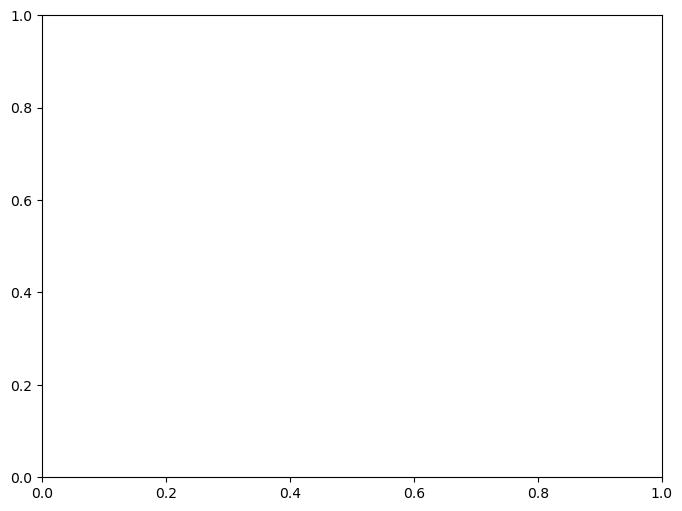

In [48]:
import json 
with open("filePaths.json", 'r') as f:
    dataset = json.load(f)

In [69]:
dataset.keys()

dict_keys(['2024F', '2024F_test', '2024G', '2024G_test', '2024I', '2024I_test', '2024I_10', '2024F_10', '2024G_10'])

In [52]:
len(dataset["2024I"]['files'])

4573

In [67]:
first_10 = int(len(dataset["2024F"]['files'])/10)
sliced_dict = dict(list(dataset["2024F"]['files'].items())[:first_10])
dataset["2024F_10"] = {"files":sliced_dict}

In [68]:
first_10 = int(len(dataset["2024G"]['files'])/10)
sliced_dict = dict(list(dataset["2024G"]['files'].items())[:first_10])
dataset["2024G_10"] = {"files":sliced_dict}

In [63]:
last_10 = int(len(dataset["2024I"]['files'])/10)
sliced_dict = dict(list(dataset["2024I"]['files'].items())[-last_10:])
dataset["2024I_10"] = {"files":sliced_dict}



{'root://xcache//store/group/phys_exotica/axol1tl/Data_ScoutingNano_withAXOscore/2024I/output_input_files_2024I.txt_4117.root': 'Events', 'root://xcache//store/group/phys_exotica/axol1tl/Data_ScoutingNano_withAXOscore/2024I/output_input_files_2024I.txt_4118.root': 'Events', 'root://xcache//store/group/phys_exotica/axol1tl/Data_ScoutingNano_withAXOscore/2024I/output_input_files_2024I.txt_4119.root': 'Events', 'root://xcache//store/group/phys_exotica/axol1tl/Data_ScoutingNano_withAXOscore/2024I/output_input_files_2024I.txt_4120.root': 'Events', 'root://xcache//store/group/phys_exotica/axol1tl/Data_ScoutingNano_withAXOscore/2024I/output_input_files_2024I.txt_4121.root': 'Events', 'root://xcache//store/group/phys_exotica/axol1tl/Data_ScoutingNano_withAXOscore/2024I/output_input_files_2024I.txt_4122.root': 'Events', 'root://xcache//store/group/phys_exotica/axol1tl/Data_ScoutingNano_withAXOscore/2024I/output_input_files_2024I.txt_4123.root': 'Events', 'root://xcache//store/group/phys_exotica

In [71]:
with open("file_list.json", "w") as f:
    json.dump(dataset, f)